# Predicting Ranking Search Results based on Content Features

##### April 22nd, 2018

## Table of Contents

### [1. Project Overview](#overview)
### [2. Problem Statement](#statement)
### [3. Solution Strategy](#solution)
### [4. Evaluation Metrics](#metrics)
### [5. Data Exploration](#exploration)
### [6. Data Cleaning](#cleaning)
### [7. Feature Engineering](#fe)
### [8. Data Visualization](#viz)
### [9. Data Preparation](#prep)
### [10.Model Development, Evaluation and Selection](#model)
### [11. Model Optimization](#optimization)
### [12. Model Interpretation](#interpret)
### [13. Conclusions and Further Improvement](#conclusion)


<a id='overview'></a>
## Project Overview

The most common entry point of the content that the World Wide Web offers are usually search engines. These tools allow users to find web pages that contain the most relevant information that answers their query. However, search engines must also navigate through an inmense amount of unrelated content to serve users the information that they really want. One other issue, is that multiple websites fight for top positions in these search results. This is because a huge number of websites create revenue through click-through rate (CTR) and visits, and since better ranking positions generate more visits, more and more websites are optimizing their content to appear better on search results. This process is known as Search Engine Optimization or SEO. 

This project focuses on using a dataset of search queries, and their search engine ranking, to understand which factors elevate a websites position on search results, and also to predict rankings for new queries. The data contains several websites and information about their contents, as well as the relation of the query to the website content. With this information, we can pinpoint what features contribute to search results position.

<a id='statement'></a>
## Problem Statement

As mentioned in the previous sections, a websites search engine ranking is key to obtaining more website visitors, more clicks through ads and purchases, and also more revenue. This project is looking to find out what factors drive this ranking up, to get a better understanding of what a website must optimize to improve its rating. Because of the nature of the data (search queries and url contents), and the objective of the problem (Rank per Query),  we are faced with a **Ranking** Problem.


<a id='solution'></a>
## Solution Strategy

Given the nature of the problem at hand, a lot of algorithms are not well optimized for the problem. Even though the problem can be interpreted as a Classification or Regression problem, the common algorithms for these types of problems don't deal well with ranked responses. On the other hand, implementations of well tested libraries for ranking problems are uncommon in Python. Because of these reasons, two algorithms (LightGBM and XGBoost) will be evaluated using the LambdaRank algorithm,  and the ranking for specific websites depending on a query will be evaluated. 

The data cleaning process will be performed on the dataset to eliminate missing values and then cross-validation will be used to find the best base model. After this, hyper-parameter random optimization will be used to find optimal parameters for the base model. When this model is created, we'll use the SHAP library to interpret the feature interactions against the ranking.

<a id='metrics'></a>
## Evaluation Metrics

To measure the quality of the ranking algorithm, we'll use a metric that takes ranking into account. This metric is called Normalized Discounted Cumulative Gain or <a href="https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG">NDCG</a>. Two assumptions are taking into account on this measure: 
1. Highly relevant results are more useful when appearing earlier in a search engine result list (have higher ranks)
2. Highly relevant results are more useful than marginally relevant results, which are in turn more useful than non-relevant results.

The premise of DCG is that highly relevant results appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically proportional to the position of the result. This calculation is dependent on the size of the result list of the query. However, since not all queries return the same number of results, NDCG was formulated to take into account what the perfect results would look like for a particular query. We can also limit how many results of the query to take into account to calculate the metric. When this step is taken, the metric is known as NDCG@K, where K is the number of results taken to calculate the NDCG. This metric allows us to evaluate the performance of the algorithm, since it should return higher ranked results first. The function to calculate this metric is the following: 


In [3]:
def dcg_at_k(r, k, method=0):
    """
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

<a id='exploration'></a>
## Data Exploration

The dataset used in this project is a search ranking dataset for Finnish websites. This dataset contains information about the website's content, like **Amount** of: Links, Images, Headers, Text and **Mentions and Counts** of a specific query on the website's content.

In [4]:
# Import libraries necessary for this project
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.mode.chained_assignment = None



In [5]:
# Set plot parameters
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 12
rcParams["patch.force_edgecolor"] = True
sns.set()

In [6]:
search_data = pd.read_csv('query_data.csv')
print("The Search Data has {} rows and {} columns.".format(search_data.shape[0],search_data.shape[1]))

The Search Data has 968 rows and 900 columns.


In [7]:
print("The data includes {} distinct URLs.".format(len(search_data.URL.unique())))

The data includes 727 distinct URLs.


In [8]:
search_data.head()

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,...,Most-Frequent-11,Most-Frequent-12,Most-Frequent-13,Most-Frequent-14,Most-Frequent-15,Most-Frequent-16,Most-Frequent-17,Most-Frequent-18,Most-Frequent-19,Most-Frequent-20
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,...,merkkikorjaamon,härskisti,käräytti,huijanneen,asiakasta,selviytyjien,kokkosen,mies,kiti,jari
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,...,tarvitsee,omenan,ohjaaminen,halajavalle,perinteisten,lentokoneen,2018,äidillesi,helsinki,äitienpäiväelämystä
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,...,smart,varkauksilta,sneaker,polaroid,mikroon,copyright,spralla,wars,the,tile
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,...,äiti,äitienpäivä,lahjat,surkein,lahja,lääkärin,isän,terveydenhuollon,luot,maksupäivät
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,...,teette,uusimmat,suosituimmat,sai,toimii,otettu,kuva,mummon,kuvasta,ostaa


There's also an extra dataset, that contains external information about the websites. 

In [9]:
extra_data = pd.read_excel('netpeak checker (733)_joni.xlsx')
extra_data.head()

,#,URL,Response Time - On-Page : URL,Content Download Time - On-Page : URL,Outgoing Links - On-Page : URL,HTML Size - On-Page : URL,Content Size - On-Page : URL,Sites Linking In - Alexa : Host,Related Pages - Google SERP : Host
0,1,https://www.elamyslahjat.fi/lahjat-kategoriois...,1812,113,303,136120,10873,78,5
1,2,https://www.alphageek.fi/ystavanpaivalahja/,1230,0,0,460,107,39,0
2,3,https://www.coolstuff.fi/tag/Ystavanpaiva,442,101,495,385671,7611,58,5
3,4,https://www.menaiset.fi/keskustelu/305/ketju/y...,858,3,284,151346,6941,547,3
4,5,https://www.lahjat.fi/ystavanpaivalahjat,214,224,713,364087,28332,7,8


This extra information includes:

- Response Time: The time taken for the website to respond to a request.
- Content Download Time: The time taken for all website content to download.
- Outgoing Links: Links to other pages. 
- HTML Size: Size of the website including HTML tags.
- Content Size: Size of the website taking just the content into account. 
- Sites Linking in Alexa: Websites that link into this page, based on Amazon Alexa results. 
- Related Pages in Google SERP: Related pages based on Google.

To merge it into the original dataset, we'll use the URL as a common field.

In [10]:
search_data = search_data.merge(extra_data.drop('#',axis=1),how='left')
search_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 0 to 967
Columns: 907 entries, Query to Related Pages - Google SERP : Host
dtypes: float64(199), int64(686), object(22)
memory usage: 6.7+ MB


### Feature Observations 

In [11]:
search_data.iloc[:,:16].head()

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,External-Links,Amount-Of-Text,Image-Count,Title-Used,Meta-Keywords-Count,Meta-Description-Length
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,34,13108,118,1,0,110
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,10,957,64,1,3,113
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,23,39713,286,1,0,134
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,21,5710,46,1,6,199
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,31,4547,19,1,0,209


The first columns contain several groups: 

- Query: Search phrase used in the search engine.
- Rank: The ranking of the website in the search results were 1 = Highest and 10 = Lowest.
- URL: The link that leads to the website result of the search engine.
- Hi Count: The total amount of headers of a specific type inside the websites HTML.
- Hi Length: The total length of the Header content inside the websites content. 
- Internal Links: Amount of Links to other pages inside the website.
- External Links: Amount of Links to other pages outside the website.
- Amount of Text: Total length of text inside the content of the website.
- Image Count : Number of Images inside the Website
- Title Used: If a title was used inside the site. 
- Meta Keywords Count: Amount of Meta Keywords inside the HTML. 
- Meta Description Length: Length of the Meta description of the HTML.

The rest of the features are grouped according to the query itself. We'll create a function to visualize them:

In [12]:
def keyword_columns(columns,keyword):
    return [col for col in columns if keyword in col]
mentions_cols = keyword_columns(search_data.columns,'Mentions')
search_data[mentions_cols].head(5)

,[ampumarata]-Mentions,[champagne in the sky]-Mentions,[cocktails in the sky]-Mentions,[crosskart]-Mentions,[dinner in the sky]-Mentions,[dinner in the sky helsinki]-Mentions,[driftaus]-Mentions,[drifting]-Mentions,[drinkkikurssi]-Mentions,[elämyslahjat]-Mentions,...,[ylioppilaslahja tytölle]-Img-Alt-Mentions,[ylioppilaslahjaideoita]-Img-Alt-Mentions,[ylioppilaslahjavinkit]-Img-Alt-Mentions,[ystävänpäivälahja]-Img-Alt-Mentions,[ystävänpäivälahja miehelle]-Img-Alt-Mentions,[ystävänpäivälahja naiselle]-Img-Alt-Mentions,[ystävänpäivälahja poikaystävälle]-Img-Alt-Mentions,[ystävänpäivälahja tyttöystävälle]-Img-Alt-Mentions,[äitienpäivälahja]-Img-Alt-Mentions,[äitienpäivälahja netistä]-Img-Alt-Mentions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The mentions columns indicate the mentions of all other keywords in the same page. It's divided in two: image alt mentions and text mentions. These columns represent a count of how many times they appear.

In [13]:
in_url_cols = keyword_columns(search_data.columns,'In-URL')
search_data[in_url_cols].head(5)

,[ampumarata]-In-URL,[champagne in the sky]-In-URL,[cocktails in the sky]-In-URL,[crosskart]-In-URL,[dinner in the sky]-In-URL,[dinner in the sky helsinki]-In-URL,[driftaus]-In-URL,[drifting]-In-URL,[drinkkikurssi]-In-URL,[elämyslahjat]-In-URL,...,[ylioppilaslahja tytölle]-In-URL,[ylioppilaslahjaideoita]-In-URL,[ylioppilaslahjavinkit]-In-URL,[ystävänpäivälahja]-In-URL,[ystävänpäivälahja miehelle]-In-URL,[ystävänpäivälahja naiselle]-In-URL,[ystävänpäivälahja poikaystävälle]-In-URL,[ystävänpäivälahja tyttöystävälle]-In-URL,[äitienpäivälahja]-In-URL,[äitienpäivälahja netistä]-In-URL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The in URL columns denote if the search keyword is in the URL.

In [14]:
in_footer_cols = keyword_columns(search_data.columns,'In-Footer')
search_data[in_footer_cols].head(5)

,[ampumarata]-In-Footer,[champagne in the sky]-In-Footer,[cocktails in the sky]-In-Footer,[crosskart]-In-Footer,[dinner in the sky]-In-Footer,[dinner in the sky helsinki]-In-Footer,[driftaus]-In-Footer,[drifting]-In-Footer,[drinkkikurssi]-In-Footer,[elämyslahjat]-In-Footer,...,[ylioppilaslahja tytölle]-In-Footer,[ylioppilaslahjaideoita]-In-Footer,[ylioppilaslahjavinkit]-In-Footer,[ystävänpäivälahja]-In-Footer,[ystävänpäivälahja miehelle]-In-Footer,[ystävänpäivälahja naiselle]-In-Footer,[ystävänpäivälahja poikaystävälle]-In-Footer,[ystävänpäivälahja tyttöystävälle]-In-Footer,[äitienpäivälahja]-In-Footer,[äitienpäivälahja netistä]-In-Footer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The In Footer columns denote if the keyword is in the footer.

In [15]:
in_H_cols = keyword_columns(search_data.columns,'Count-H')
search_data[in_H_cols].head(5)

,[ampumarata]-Count-H1,[champagne in the sky]-Count-H1,[cocktails in the sky]-Count-H1,[crosskart]-Count-H1,[dinner in the sky]-Count-H1,[dinner in the sky helsinki]-Count-H1,[driftaus]-Count-H1,[drifting]-Count-H1,[drinkkikurssi]-Count-H1,[elämyslahjat]-Count-H1,...,[ylioppilaslahja tytölle]-Count-H3,[ylioppilaslahjaideoita]-Count-H3,[ylioppilaslahjavinkit]-Count-H3,[ystävänpäivälahja]-Count-H3,[ystävänpäivälahja miehelle]-Count-H3,[ystävänpäivälahja naiselle]-Count-H3,[ystävänpäivälahja poikaystävälle]-Count-H3,[ystävänpäivälahja tyttöystävälle]-Count-H3,[äitienpäivälahja]-Count-H3,[äitienpäivälahja netistä]-Count-H3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The in $H_{i}$ columns   denote the number of times a keyword appears in the page, specifically in Header tags.   

In [16]:
in_anchor_cols = keyword_columns(search_data.columns,'In-Anchor')
search_data[in_anchor_cols].head(5)

,[ampumarata]-In-Anchor-Text,[champagne in the sky]-In-Anchor-Text,[cocktails in the sky]-In-Anchor-Text,[crosskart]-In-Anchor-Text,[dinner in the sky]-In-Anchor-Text,[dinner in the sky helsinki]-In-Anchor-Text,[driftaus]-In-Anchor-Text,[drifting]-In-Anchor-Text,[drinkkikurssi]-In-Anchor-Text,[elämyslahjat]-In-Anchor-Text,...,[ylioppilaslahja tytölle]-In-Anchor-Text,[ylioppilaslahjaideoita]-In-Anchor-Text,[ylioppilaslahjavinkit]-In-Anchor-Text,[ystävänpäivälahja]-In-Anchor-Text,[ystävänpäivälahja miehelle]-In-Anchor-Text,[ystävänpäivälahja naiselle]-In-Anchor-Text,[ystävänpäivälahja poikaystävälle]-In-Anchor-Text,[ystävänpäivälahja tyttöystävälle]-In-Anchor-Text,[äitienpäivälahja]-In-Anchor-Text,[äitienpäivälahja netistä]-In-Anchor-Text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In anchor denotes if the search keyword appears in anchor text.

In [17]:
most_frequent_cols = keyword_columns(search_data.columns,'Most-Frequent')
search_data[most_frequent_cols].head(5)

,Most-Frequent-1,Most-Frequent-2,Most-Frequent-3,Most-Frequent-4,Most-Frequent-5,Most-Frequent-6,Most-Frequent-7,Most-Frequent-8,Most-Frequent-9,Most-Frequent-10,Most-Frequent-11,Most-Frequent-12,Most-Frequent-13,Most-Frequent-14,Most-Frequent-15,Most-Frequent-16,Most-Frequent-17,Most-Frequent-18,Most-Frequent-19,Most-Frequent-20
0,räikkösen,seurasi,puukottaja,bouanane,karmeista,pääsi,aikeistaan,turun,puhui,kojelautakamera,merkkikorjaamon,härskisti,käräytti,huijanneen,asiakasta,selviytyjien,kokkosen,mies,kiti,jari
1,tarjoavat,vaihtoehtoja,sopii,viettää,elämyksiin,rauhoittavat,sisäänkäynnin,rentouttavat,sopiva,äiti,tarvitsee,omenan,ohjaaminen,halajavalle,perinteisten,lentokoneen,2018,äidillesi,helsinki,äitienpäiväelämystä
2,osta,lékué,tunteiden,zenkuru,cozy,vagaborn,star,kit,sugru,speaker,smart,varkauksilta,sneaker,polaroid,mikroon,copyright,spralla,wars,the,tile
3,vanhemmuus,varaa,kasvatus,lääkärille,kysy,äidin,suosittelemme,lapsen,asiantuntijalta,lahjan,äiti,äitienpäivä,lahjat,surkein,lahja,lääkärin,isän,terveydenhuollon,luot,maksupäivät
4,lapsen,saa,pojan,mummu,lahjaksi,käden,mummolle,äitienpäivänä,saavat,tilattiin,teette,uusimmat,suosituimmat,sai,toimii,otettu,kuva,mummon,kuvasta,ostaa


The most frequent columns denote which words are the most common in the content of the website. With this we are finished getting an understanding of the features of the dataset.

<a id='cleaning'></a>
## Data Cleaning

Before cleaning the data, we must take a look at which  features have missing values. 

In [18]:
null_count = pd.isnull(search_data).sum()
null_count[null_count > 0]

[ampumarata]-Mentions                                   21
[champagne in the sky]-Mentions                         21
[cocktails in the sky]-Mentions                         21
[crosskart]-Mentions                                    21
[dinner in the sky]-Mentions                            21
[dinner in the sky helsinki]-Mentions                   21
[driftaus]-Mentions                                     21
[drifting]-Mentions                                     21
[drinkkikurssi]-Mentions                                21
[elämyslahjat]-Mentions                                 21
[escape room]-Mentions                                  21
[hartiahieronta]-Mentions                               21
[hieronta]-Mentions                                     21
[hieronta lahjaksi]-Mentions                            21
[hierontalahjakortti]-Mentions                          21
[huonepakopeli]-Mentions                                21
[huonepakopelit]-Mentions                               

Let's reason why some features have missing values: 

- Mentions: The website has no mentions of this keyword. 
- Most Frequent: The website doesn't have enough distinct content to have a word appear in the most frequents.
- Extra Columns: The URL wasn't included in the extra data.

For the mentions columns, we'll fill missing values with 0, as we'll treat them as if they weren't mentioned. For the most frequent columns, we'll fill missing with None, as it denotes that there weren't enough words to satisfy the most frequent  ii  requirement.

In [19]:
search_data[most_frequent_cols] = search_data[most_frequent_cols].fillna('None')
search_data = search_data.fillna(0)
null_count = pd.isnull(search_data).sum()
null_count[null_count > 0]

Series([], dtype: int64)

#### Outliers

In [20]:
search_data.describe()

,Rank,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,External-Links,Amount-Of-Text,...,[ystävänpäivälahja tyttöystävälle]-In-Anchor-Text,[äitienpäivälahja]-In-Anchor-Text,[äitienpäivälahja netistä]-In-Anchor-Text,Response Time - On-Page : URL,Content Download Time - On-Page : URL,Outgoing Links - On-Page : URL,HTML Size - On-Page : URL,Content Size - On-Page : URL,Sites Linking In - Alexa : Host,Related Pages - Google SERP : Host
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,...,968.0,968.000000,968.0,968.000000,968.000000,968.000000,9.680000e+02,968.000000,9.680000e+02,968.000000
mean,5.558884,1.566116,6.049587,8.483471,28.324380,16.932851,23.609504,207.457645,19.873967,5632.217975,...,0.0,0.148760,0.0,772.510331,57.989669,214.854339,1.550459e+05,9578.435950,1.341305e+05,7.114669
std,3.303760,7.658816,12.647378,17.438435,21.853847,21.418290,34.181286,328.336389,27.569572,9681.839449,...,0.0,0.356036,0.0,808.529027,145.779905,258.011849,2.163439e+05,9015.333062,8.087253e+05,9.501988
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.000000,1.000000,0.000000,0.000000,14.000000,0.000000,0.000000,37.000000,4.000000,1054.750000,...,0.0,0.000000,0.0,249.000000,3.000000,52.000000,4.336875e+04,3482.750000,7.000000e+00,3.000000
50%,5.000000,1.000000,2.000000,3.500000,24.000000,13.000000,15.000000,93.500000,10.000000,2540.000000,...,0.0,0.000000,0.0,502.500000,19.000000,125.000000,1.077915e+05,7383.000000,7.800000e+01,5.000000
75%,8.000000,1.000000,7.000000,9.000000,41.000000,26.000000,32.000000,243.500000,25.000000,5890.000000,...,0.0,0.000000,0.0,1097.000000,52.000000,274.000000,1.697510e+05,12868.000000,3.662500e+02,7.000000
max,49.000000,234.000000,153.000000,157.000000,142.000000,256.000000,498.000000,3508.000000,430.000000,86935.000000,...,0.0,1.000000,0.0,9269.000000,1420.000000,1996.000000,1.759817e+06,62169.000000,7.419881e+06,48.000000


While there are some outliers in the numerical data, since the data is already really small, we've decided to not remove any outliers, and use models robust to outlers. But we'll remove Rank outliers, which are those greater than 10.

In [21]:
search_data = search_data.loc[search_data.Rank <= 10].reset_index(drop=True)
print("The Search Data has {} rows and {} columns.".format(search_data.shape[0],search_data.shape[1]))

The Search Data has 966 rows and 907 columns.


With the cleaning done, we'll proceed with Feature Engineering. 

<a id='fe'></a>
## Feature Engineering

#### Query appears in all types of text

In [22]:
keywords = [col.replace('-In-URL','') for col in in_url_cols]
keywords[:10]

['[ampumarata]',
 '[champagne in the sky]',
 '[cocktails in the sky]',
 '[crosskart]',
 '[dinner in the sky]',
 '[dinner in the sky helsinki]',
 '[driftaus]',
 '[drifting]',
 '[drinkkikurssi]',
 '[elämyslahjat]']

In [23]:
in_cols = keyword_columns(search_data.columns,'-In-')
for kw in keywords:
    keyword_in_cols = [col for col in in_cols if kw in col]
    in_all_col = "{}_In_All".format(kw)
    search_data[in_all_col] = (search_data[keyword_in_cols].sum(axis=1) > 0).astype(np.int8)
search_data.head(10)

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,...,[ylioppilaslahja tytölle]_In_All,[ylioppilaslahjaideoita]_In_All,[ylioppilaslahjavinkit]_In_All,[ystävänpäivälahja]_In_All,[ystävänpäivälahja miehelle]_In_All,[ystävänpäivälahja naiselle]_In_All,[ystävänpäivälahja poikaystävälle]_In_All,[ystävänpäivälahja tyttöystävälle]_In_All,[äitienpäivälahja]_In_All,[äitienpäivälahja netistä]_In_All
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,...,0,0,0,0,0,0,0,0,0,0
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,...,0,0,0,1,0,0,0,0,1,0
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,...,0,0,0,0,0,0,0,0,0,0
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,...,0,0,0,0,0,0,0,0,1,0
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,...,0,0,0,0,0,0,0,0,0,0
5,äitienpäivälahja,6,https://www.vauva.fi/keskustelu/3977418/ketju/...,1,15,1,31,11,14,232,...,0,0,0,0,0,0,0,0,0,0
6,äitienpäivälahja,7,https://kaksplus.fi/threads/vinkkejae-lapsen-o...,1,0,25,44,0,23,90,...,0,0,0,0,0,0,0,0,0,0
7,äitienpäivälahja,8,https://www.omakoti.fi/lahjaideat/aitienpaival...,1,4,7,32,41,41,87,...,0,0,0,0,0,0,0,0,0,0
8,äitienpäivälahja,9,http://www.iltalehti.fi/perhe/2010050411590193...,1,9,0,34,13,0,562,...,0,0,0,0,0,0,0,0,0,0
9,äitienpäivälahja,10,https://www.gogift.com/fi-FI/occasion/aitienpaiva,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Header Total 

In [24]:
search_data['H_Total'] = search_data[['H1-Count','H2-Count','H3-Count']].sum(axis=1)
search_data['H_Total_Length'] = search_data[['H1-Length','H2-Length','H3-Length']].sum(axis=1)
for kw in keywords:
    keyword_in_cols = [col for col in in_H_cols if kw in col]
    H_Total_col = "{}_H_Total".format(kw)
    search_data[H_Total_col] = (search_data[keyword_in_cols].sum(axis=1)).astype(np.int8)
search_data.head()

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,...,[ylioppilaslahja tytölle]_H_Total,[ylioppilaslahjaideoita]_H_Total,[ylioppilaslahjavinkit]_H_Total,[ystävänpäivälahja]_H_Total,[ystävänpäivälahja miehelle]_H_Total,[ystävänpäivälahja naiselle]_H_Total,[ystävänpäivälahja poikaystävälle]_H_Total,[ystävänpäivälahja tyttöystävälle]_H_Total,[äitienpäivälahja]_H_Total,[äitienpäivälahja netistä]_H_Total
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,...,0,0,0,0,0,0,0,0,1,0
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,...,0,0,0,0,0,0,0,0,1,0
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,...,0,0,0,0,0,0,0,0,1,0
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,...,0,0,0,0,0,0,0,0,2,0
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,...,0,0,0,0,0,0,0,0,1,0


#### Total number of Links

In [25]:
search_data['Total_Links'] = search_data['Internal-Links'] + search_data['External-Links']
search_data.head()

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,...,[ylioppilaslahjaideoita]_H_Total,[ylioppilaslahjavinkit]_H_Total,[ystävänpäivälahja]_H_Total,[ystävänpäivälahja miehelle]_H_Total,[ystävänpäivälahja naiselle]_H_Total,[ystävänpäivälahja poikaystävälle]_H_Total,[ystävänpäivälahja tyttöystävälle]_H_Total,[äitienpäivälahja]_H_Total,[äitienpäivälahja netistä]_H_Total,Total_Links
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,...,0,0,0,0,0,0,0,1,0,534
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,...,0,0,0,0,0,0,0,1,0,293
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,...,0,0,0,0,0,0,0,1,0,948
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,...,0,0,0,0,0,0,0,2,0,190
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,...,0,0,0,0,0,0,0,1,0,222


#### URL Is Secure?

In [26]:
search_data['Is_Secure'] = search_data.URL.str.contains('https')
search_data.Is_Secure.describe()

count      966
unique       2
top       True
freq       717
Name: Is_Secure, dtype: object

We are done creating new features, but we have run into a dimensionality problem.

In [27]:
print("The Search Data has {} rows and {} columns.".format(search_data.shape[0],search_data.shape[1]))

The Search Data has 966 rows and 1103 columns.


There's a higher number of features than examples in the data! This will make learning a model for the data almost impossible, because there are too many features to learn from, and not enough examples to differentiate the data. Because of this, we must reduce the number of columns. Since we know that the majority of the columns are just a count of a query in the website's content, we can group all the columns into one. Each one of these can be grouped into one column, which represents the count of the type of content in the website about the query. For example, instead of having a mentions column for each query, we'll have a Query Mentions column, which will only have the mentions of the specific query on the URL, instead of the mentions of all queries. This will greatly reduce the number of features, without applying fancy dimensionality reduction algorithms, and keeping sense of the data.

In [28]:
def get_query_count_data(search_data,col_types,queries,query_brackets):
    new_search_data = search_data.copy()
    new_query_cols = ['Query{}'.format(ct) for ct in col_types]
    #Initialize the new columns with 0.
    for nq in new_query_cols:
        new_search_data[nq] = 0
        
    for i,q in enumerate(queries):
        #Get all columns which mention the query.
        query_mention_cols = [col for col in search_data.columns if query_brackets[i] in col]
        #Protection for cases in which the query has no columns.
        if len(query_mention_cols) > 0:
            #Subset the data only for columns which contain the query.
            query_mention_values = search_data.loc[search_data.Query == q][query_mention_cols]
            query_mention_values.columns = new_query_cols
            # Replace the values for the new columns for the query with the values for the old columns.
            for nq in new_query_cols:
                new_search_data.loc[new_search_data.Query == q, nq] = query_mention_values[nq]
            
            # Drop the old columns of the query.
            new_search_data.drop(query_mention_cols,axis=1,inplace=True)
        else:
            continue
    return new_search_data

In [29]:
queries = search_data.Query.unique()
query_brackets = ['[{}]'.format(q) for q in queries]
query_types = [q.replace(query_brackets[0],'') for q in search_data.columns if query_brackets[0] in q]
query_types[:10]

['-Mentions',
 '-Img-Alt-Mentions',
 '-In-URL',
 '-In-Footer',
 '-Count-P',
 '-Count-H1',
 '-Count-H2',
 '-Count-H3',
 '-In-Anchor-Text',
 '_In_All']

In [30]:
search_data = get_query_count_data(search_data,query_types,queries,query_brackets)
print("The Search Data has {} rows and {} columns.".format(search_data.shape[0],search_data.shape[1]))

The Search Data has 966 rows and 58 columns.


We'll also drop the columns which contain the information about the most frequent words in the content. These features are hard to integrate into  a model, and will only increase the dimensionality of the data.

In [31]:
search_data = search_data.drop(most_frequent_cols,axis=1)
search_data.head()

,Query,Rank,URL,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,...,Query-Img-Alt-Mentions,Query-In-URL,Query-In-Footer,Query-Count-P,Query-Count-H1,Query-Count-H2,Query-Count-H3,Query-In-Anchor-Text,Query_In_All,Query_H_Total
0,äitienpäivälahja,1,https://www.is.fi/perhe/art-2000000753114.html,3,8,9,24,15,83,500,...,0.0,0,0,0,1,0,0,0,0,1
1,äitienpäivälahja,2,https://www.elamyslahjat.fi/lahjat-kategoriois...,1,0,0,22,0,0,283,...,0.0,0,0,1,1,0,0,1,1,1
2,äitienpäivälahja,3,https://www.coolstuff.fi/tag/Aitienpaivalahjat,1,0,6,22,0,78,925,...,263.0,0,0,2,1,0,0,0,0,1
3,äitienpäivälahja,4,http://www.terve.fi/vanhemmuus-ja-kasvatus/aid...,1,16,37,47,15,37,169,...,0.0,0,0,0,1,0,1,1,1,2
4,äitienpäivälahja,5,https://www.vauva.fi/keskustelu/326479/ketju/a...,1,13,1,37,12,13,191,...,0.0,0,0,2,1,0,0,0,0,1


With that we are done with Feature Engineering. A bit of an unorthodox method of it was applied here, since we ended with less features than what we started with. However,  this was necessary to obtain a better model that generalizes well, and does not overfit to the complexity of large number of features. With these features, we can proceed to obtain better understanding of what affects the ranking of websites in search results. We'll achieve this through **Data Visualization**.

<a id='viz'></a>
## Data Visualization

The main objective of Data Visualization is to obtain visual understanding of how the features affect our variable of interest. In this case, our variable of interest is the ranking: with 1 being the best and 10 being the worst ranking. 

##### How do Links affect ranking?

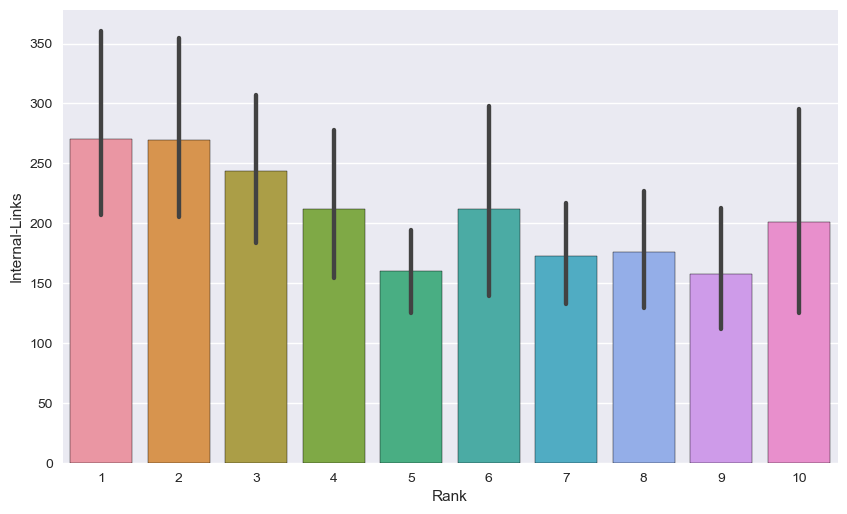

In [32]:
sns.barplot(y=search_data['Internal-Links'],x=search_data.Rank)

In general, sites with a higher amount of internal links have higher rankings. 

##### How does the amount of text in the page affect the ranking?

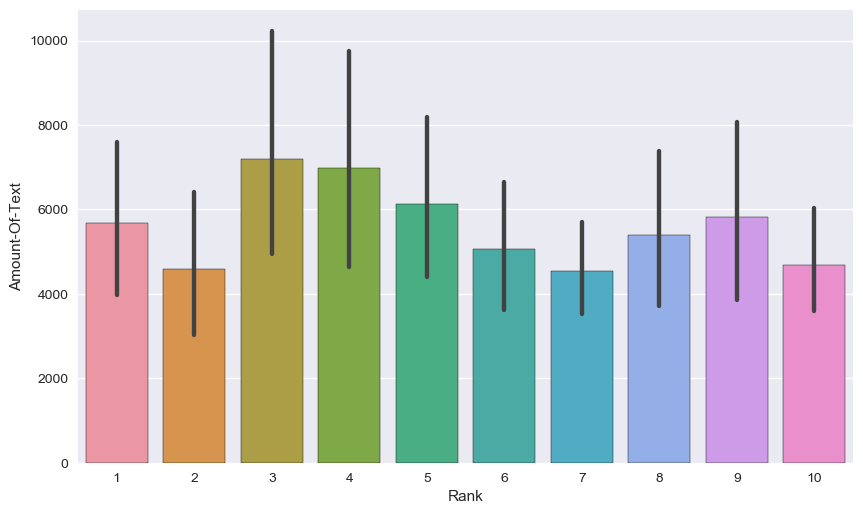

In [33]:
sns.barplot(y=search_data['Amount-Of-Text'],x=search_data.Rank)

While top ranking sites have low amounts of text, ranks 3 to 5 have a higher than average amount of text, then it decreases with ranks. This suggests a nonlinear relationship between the amount of text and rank, or some high text count examples that induce variation, noted by the black lines inside the bars.

##### How does the Meta Description Length affect ranking?

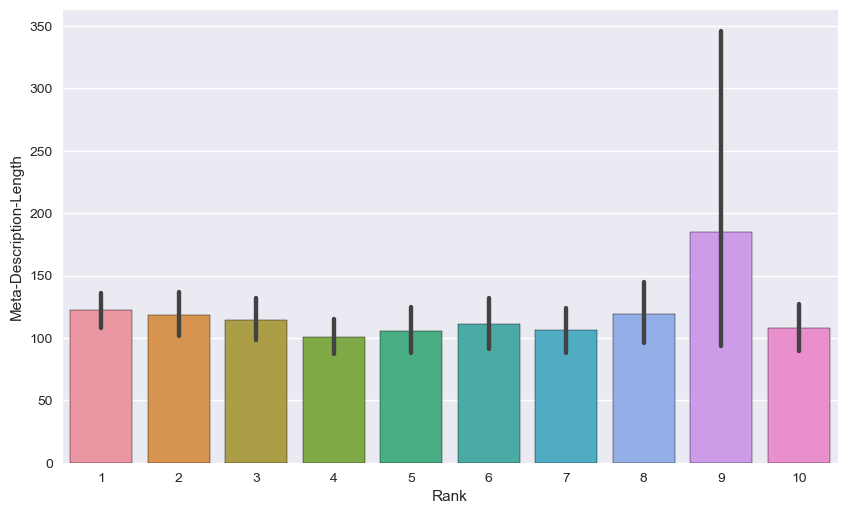

In [34]:
sns.barplot(y=search_data['Meta-Description-Length'],x=search_data.Rank)

Meta Description lengths lower as ranks also get lower, then after rank 5 it gets higher as the ranks also increase. Although there is a huge value for one particular example in rank 9.

##### How does response time affect the ranking?

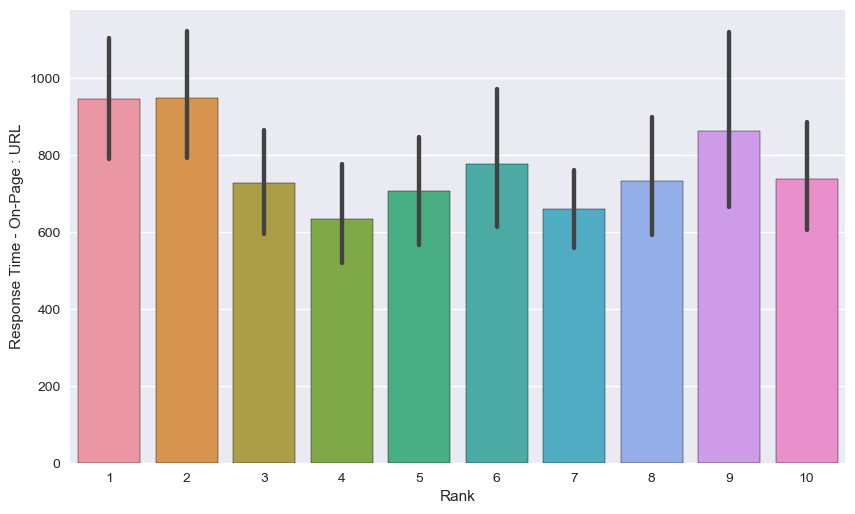

In [35]:
sns.barplot(y=search_data['Response Time - On-Page : URL'],x=search_data.Rank)

The top 2 ranks have the highest response time on average, while the rest of the ranks have low response times. This may indicate that although these top pages take longer to respond, they also have the exact content that the query needs.

##### Do secure websites rank higher?

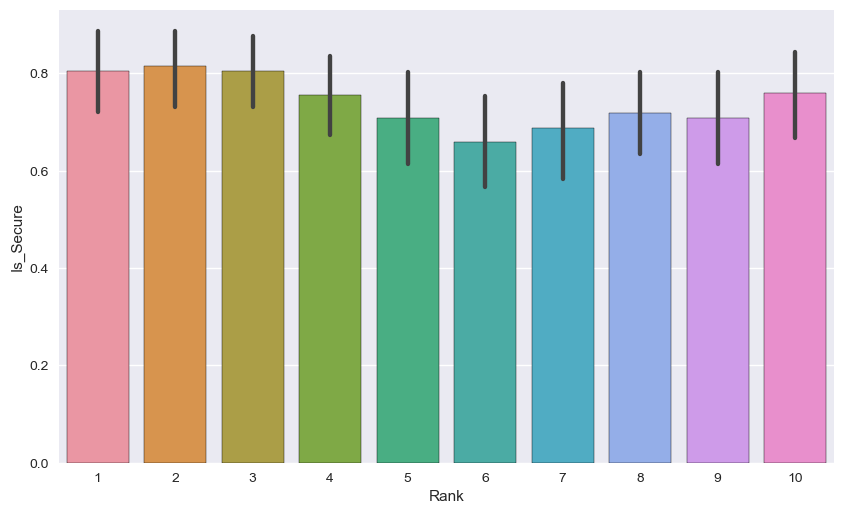

In [36]:
sns.barplot(y=search_data['Is_Secure'],x=search_data.Rank)

Secure websites generally rank higher that non-secure ones.

##### How does content download time affect ranking?

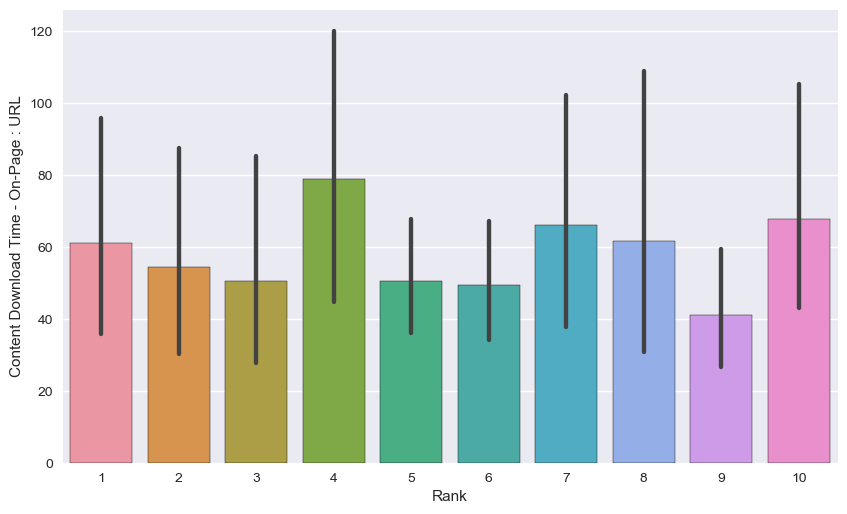

In [37]:
sns.barplot(y=search_data['Content Download Time - On-Page : URL'],x=search_data.Rank)

On average, it seems lower content download time increases ranking. This rings true with what is expected, since slower to load sites are not great for users.

Text(0.5,1,'Correlations between features ')

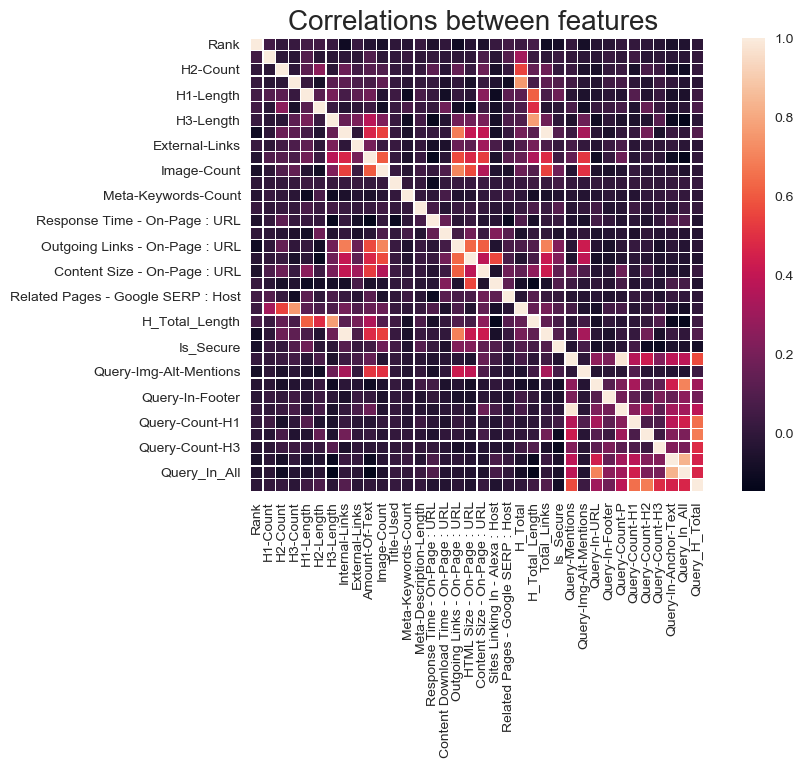

In [38]:
corr = search_data.corr()
sns.heatmap(corr, vmax=1, square=True, linewidths=.2,)
plt.title('Correlations between features ', size=20)

While no feature has a high impact over rank, it seems most features have some low impact over it. This means a combination of them may yeild better correlation with ranking. With a better idea of how the features affect the ranking, we can proceed with creating the models.

<a id='prep'></a>
## Data Preparation

While the data itself has been processed and cleaned, it isn't ready for modelling. The algorithms that will be used expect fully numerical data, which our dataset doesn't have.

In [39]:
search_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 38 columns):
Query                                    966 non-null object
Rank                                     966 non-null int64
URL                                      966 non-null object
H1-Count                                 966 non-null int64
H2-Count                                 966 non-null int64
H3-Count                                 966 non-null int64
H1-Length                                966 non-null int64
H2-Length                                966 non-null int64
H3-Length                                966 non-null int64
Internal-Links                           966 non-null int64
External-Links                           966 non-null int64
Amount-Of-Text                           966 non-null int64
Image-Count                              966 non-null int64
Title-Used                               966 non-null int64
Meta-Keywords-Count                      966 non-null

We first have to remove these non-numerical features, by removing them or transforming them. For the queries, we'll transform them into numbers. This is because the algorithms we'll use for ranking, assume that the results of the queries are grouped together. For the URLs, we'll remove them, as they are non-informative features.

In [40]:
model_data = search_data.drop(['Query','URL'],axis=1)
model_data = model_data.loc[model_data.Rank <=10]
print("The Modelling Data has {} rows and {} columns.".format(model_data.shape[0],model_data.shape[1]))

The Modelling Data has 966 rows and 36 columns.


The ranking algorithms also expects ranks to be on descending order. In our data, the first and best results have lower numbers (1,2,3), while ranking algorithms expect the best results to have higher numbers. Because of this, we'll invert the numbers of the rankings, to be more model-friendly.

In [41]:
rank_replacement_dict = {i:11-i for i in range(1,11) }
model_data.Rank = model_data.Rank.replace(rank_replacement_dict)
model_data.head()

,Rank,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,External-Links,Amount-Of-Text,...,Query-Img-Alt-Mentions,Query-In-URL,Query-In-Footer,Query-Count-P,Query-Count-H1,Query-Count-H2,Query-Count-H3,Query-In-Anchor-Text,Query_In_All,Query_H_Total
0,10,3,8,9,24,15,83,500,34,13108,...,0.0,0,0,0,1,0,0,0,0,1
1,9,1,0,0,22,0,0,283,10,957,...,0.0,0,0,1,1,0,0,1,1,1
2,8,1,0,6,22,0,78,925,23,39713,...,263.0,0,0,2,1,0,0,0,0,1
3,7,1,16,37,47,15,37,169,21,5710,...,0.0,0,0,0,1,0,1,1,1,2
4,6,1,13,1,37,12,13,191,31,4547,...,0.0,0,0,2,1,0,0,0,0,1


Finally, we'll reinsert the queries into the data, but as numbers. We'll also order the data based on the rank and number of the query. This way, every 10 rows will include one query search results, ordered by the most relevant result to the least relevant result. This way, our data is ready for modelling.

In [42]:
query_encoder =  LabelEncoder().fit(search_data['Query'])
model_data['qid'] = query_encoder.transform(search_data['Query'])
model_data = model_data.sort_values(by = ['qid','Rank'],ascending=False)
model_data.head()

,Rank,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,External-Links,Amount-Of-Text,...,Query-In-URL,Query-In-Footer,Query-Count-P,Query-Count-H1,Query-Count-H2,Query-Count-H3,Query-In-Anchor-Text,Query_In_All,Query_H_Total,qid
10,10,1,0,6,22,0,78,925,23,39713,...,0,0,0,0,0,0,0,0,0,96
11,9,1,4,9,28,32,18,618,12,6191,...,0,0,1,0,0,0,0,0,0,96
12,8,1,53,0,24,20,0,210,8,1675,...,0,0,1,1,0,0,0,0,1,96
13,7,1,0,0,22,0,0,283,10,957,...,0,0,0,0,0,0,0,0,0,96
14,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96


<a id='model'></a>
## Model Development, Evaluation and Selection

As this is a ranking problem, we are limited in the kinds of models we can use on the data. The algorithms used on these kinds of problems are called **Learning to Rank** algorithms. Learning to Rank (LTR) is a class of techniques that apply supervised machine learning (ML) to solve ranking problems. The main difference between LTR and traditional supervised ML is this:

- Traditional ML solves a prediction problem (classification or regression) on a single instance at a time. E.g. if you are doing spam detection on email, you will look at all the features associated with that email and classify it as spam or not. The aim of traditional ML is to come up with a class (spam or no-spam) or a single numerical score for that instance.

- LTR solves a ranking problem on a list of items. The aim of LTR is to come up with optimal ordering of those items. As such, LTR doesn't care much about the exact score that each item gets, but cares more about the relative ordering among all the items.

On the algorithms we'll use, ranking is transformed into a pairwise classification or regression problem. That means the algorithm looks at pairs of items at a time, come up with the optimal ordering for that pair of items, and then use it to come up with the final ranking for all the results. Two models will be compared that solve this problem:

- **Extreme Gradient Boosted Decision Trees or XGBoost**. XGBoost uses decision trees, structures that split the data into smaller subsets that divide the target well, combined with gradient boosting, building models in succession that learn from the previous model's mistakes. These models are also added a penalty for growing to complex, thus helping the model generalize better to new data. This model also has a very optimized implementation, and includes a pairwise loss implementation, which makes it suitable for ranking problems. 


- **Light Gradient Boosting Machine or LightGBM**. LightGBM is very similar to XGBoost, but it used a different mechanism for growing decision trees. Instead of growing the trees in a spread manner, LightGBM focuses on specific leaves of the tree first, allowing the trees to be built faster. It also includes an implementation for pairwise loss called LambdaRank, which is used for ranking problems.

To evaluate them, we'll use the NDCG@10 metric explained earlier. Let's separate the target rank from the data into two matrices.

In [43]:
X =  model_data.drop('Rank',axis=1)
y = model_data.Rank
y.head()

10    10
11     9
12     8
13     7
14     6
Name: Rank, dtype: int64

As a base, we'll build an XGBoost model for ranking. This model expects data to be in a specific DMatrix format, and each query to have its own group. 

In [44]:
# Parameters of the model
xgb_params = {
    'objective':'rank:pairwise',
    'eval_metric':'ndcg@10'
}

# Specific data format.
xgb_data = xgb.DMatrix(X.drop('qid',axis=1),y)
#Creating groups for the data.
groups = []
for qid in X.qid.unique():
    groups.append(X.loc[X.qid == qid].shape[0])
xgb_data.set_group(groups)

We'll then create a model that uses each query, site information and ranking to learn to rank the sites, and evaluate the performance of the model on a few queries.

In [45]:
#Train and Create a model.
ranking_xgb_model = xgb.train(xgb_params,xgb_data,num_boost_round=200)
#Create predictions.
ranks = ranking_xgb_model.predict(xgb_data)
#Get NDCG score for first 3 queries.
print("NDCG for query {}: {}".format(query_encoder.inverse_transform(X.qid.iloc[:10].unique()[0])
                                     ,ndcg_at_k(r=ranks[:10],k=10)))
print("NDCG for query {}: {}".format(query_encoder.inverse_transform(X.qid.iloc[10:20].unique()[0]),
                                    ndcg_at_k(r=ranks[10:20],k=10)))
print("NDCG for query {}: {}".format(query_encoder.inverse_transform(X.qid.iloc[20:30].unique()[0]),
                                     ndcg_at_k(r=ranks[20:30],k=10)))

NDCG for query äitienpäivälahja netistä: 0.9955247129436513
NDCG for query äitienpäivälahja: 0.9861257563564401
NDCG for query ystävänpäivälahjat: 0.994422580168136


This is all well and all but we are using the training data to evaluate the model. To truly evaluate a model's performance, we must use data that the model hasn't seen. We must also compare the LightGBM and XGBoost models on equal footing, to choose one to optimize at the end. To do all this, we'll use cross validation. Cross validation divides the data into training data, that will be used to create the model, and validation data, that will be used to assess its performance. Then, the validation data is added to the training data, and another subset of the data is used to validate the model. This process is repeated until all data has be used to train and validate the model. This gives us a better idea of how the model will perform in a general way. However, for ranking, cross validation works in a slightly different way. Instead of using a subset of the data, we'll use a subset of the queries. This way, we'll test on truly unseen queries and sites that the model ranks. 

In [46]:
# LightGBM Parameters
lgb_params = {
    'application':'lambdarank',
    'metric':'ndcg',
    'ndcg_at':10
}

In [47]:
def prepare_grouped_data(data,target,group_ids,model='xgb'):
    """
    Prepare groups sizes  and data based on training/testing groups.
    """
    group_data  = data.loc[data.qid.isin(group_ids)].drop('qid',axis=1) #Group data.
    target_group = target.loc[group_data.index] #Group ranks.
    if model == 'xgb':
        group_model_data = xgb.DMatrix(group_data,target_group)
    elif model == 'lgb':
        group_model_data = lgb.Dataset(group_data,target_group)
    groups = []
    for qid in group_ids:
        groups.append(data.loc[data.qid == qid].shape[0])
    group_model_data.set_group(groups)
    return group_model_data,target_group,groups

In [48]:
def calculate_mean_ndcg(test_pred,test_groups,rank=10):
    """
    Calculates the average ndcg for all queries used in testing.
    """
    i = 0
    ndcgs  = []
    for g in test_groups:
        pred_ranks = test_pred[i:i+g]
        pred_ranks = (pred_ranks - pred_ranks.min())/(pred_ranks.max() - pred_ranks.min()) # Normalize Ranks.
        ndcgs.append(ndcg_at_k(pred_ranks,rank)) #Calculate NDCG.
        i+=g
    return np.array(ndcgs).mean()

In [49]:
def cross_validate(X,y,params,groups,cv = 5,model='xgb'):
    """
    Use cross validation to assess model performance.
    """
    # Lists to save scores and iterations used to train the model.
    cv_scores = []
    best_iterations = []
    
    # Calculate size for each testing cross validation set.
    group_size = groups.shape[0]
    chunk_size = group_size // cv
    for i in range(cv):
        # Divide into training and testing groups.
        test_groups = groups[i*chunk_size:(i+1)*chunk_size]
        test_groups_set = set(test_groups)
        train_groups = [g for g in groups if g not in test_groups_set]
        # Prepare training and testing data.
        X_train,y_train,_ = prepare_grouped_data(X,y,train_groups,model)
        X_test,y_test,group_sizes = prepare_grouped_data(X,y,test_groups,model)
        #Train model and obtain predictions.
        if model == 'xgb':
            ranking_model = xgb.train(params,X_train,num_boost_round=1000,evals=[(X_test,'eval_set')],
                                     early_stopping_rounds=50,verbose_eval=False)
            test_pred = ranking_model.predict(X_test)
        elif model == 'lgb':
            eval_test = X_test.data.copy()
            ranking_model = lgb.train(params,X_train,num_boost_round=1000,valid_sets=[X_test],
                                     early_stopping_rounds=50,verbose_eval=False)
            test_pred = ranking_model.predict(eval_test)
        
        #Evaluate model and obtain number of training rounds and NDCG score.
        cv_ndcg = calculate_mean_ndcg(test_pred,group_sizes)
        best_iterations.append(ranking_model.best_iteration)
        cv_scores.append(cv_ndcg)
    return np.array(cv_scores).mean(),np.array(best_iterations).mean().astype(int)

With all the functions prepared, we can proceed evaluation both models, to pick the one that generalizes better.

In [50]:
np.random.seed(1) #Set a random seed for reproducible results.

In [51]:
xgb_score,_ = cross_validate(X,y,xgb_params,X.qid.unique()) 
print("Average CV NDCG Score for XGBoost: {}".format(xgb_score))

Average CV NDCG Score for XGBoost: 0.8527222649086678


In [52]:
lgb_score,_ = cross_validate(X,y,lgb_params,X.qid.unique(),model='lgb') 
print("Average CV NDCG Score for LightGBM: {}".format(lgb_score))

Average CV NDCG Score for LightGBM: 0.8482849396640116


Based on Cross Validation scores, we'll use XGBoost for optimization and model interpretatin. 

<a id='optimization'></a>
## Model Optimization 

Models have a lot of parameters that can be tuned to fit better for a particular problem. XGBoost is no exception to this. The possible combinations of values that these parameters can take are infinite. However, we can limit the amount of possible values to pick from and simplify the combinations of parameters to be used. To do this, we first define a dictionary of lists of possible values of the parameters we want to tune:

In [53]:
params_dist = {
    'objective':['rank:pairwise'],
    'eval_metric':['ndcg@10'],
    'eta':[0.01,0.1],
    'max_depth':[5,7,9,11],
    'lambda':[1,5],
    'alpha':[1,5],
    'colsample_bytree':[0.75,1]
}

We then define a function to pick a value for each parameter at random.

In [54]:
def pick_random_params(params_dist):
    new_params=dict()
    for param,values in params_dist.items():
        choice = np.random.choice(len(values))
        new_params[param] = values[choice]
    return new_params

And finally, we combine cross validation with random parameter choosing to obtain a combination of parameters that optimizes performance. This is known as **Randomized Search Optimization**. This way, we can choose a combination of parameters for the XGBoost model that optimizes performance higher than the base values we used earlier.

In [55]:
def random_optimization(params_dist,X,y,groups,cv=5,rounds=10):
    best_params = None
    best_score = 0
    best_rounds = 0
    for i in range(rounds):
        # Pick Random parameters and cross validate them.
        round_params = pick_random_params(params_dist)
        score,rounds = cross_validate(X,y,round_params,X.qid.unique(),5,'xgb')
        print("Score on round {}: {}".format(i+1,score))
        if score > best_score:
            best_score = score
            best_rounds = rounds
            best_params =round_params
    
    return best_params,best_score,best_rounds

In [56]:
best_params,best_score,best_rounds = random_optimization(params_dist,X,y,groups)

Score on round 1: 0.8466795761186617
Score on round 2: 0.8514883012331437
Score on round 3: 0.8513938992560405
Score on round 4: 0.8457979333327541
Score on round 5: 0.8464884555861797
Score on round 6: 0.8479492971693421
Score on round 7: 0.846519139661083
Score on round 8: 0.8414337366135312
Score on round 9: 0.8524833566447562
Score on round 10: 0.8578542743902815


In [57]:
print("The best NDCG obtained was {}".format(best_score))
print("The best parameters obtained where {}".format(best_params))

The best NDCG obtained was 0.8578542743902815
The best parameters obtained where {'objective': 'rank:pairwise', 'eval_metric': 'ndcg@10', 'eta': 0.1, 'max_depth': 9, 'lambda': 5, 'alpha': 5, 'colsample_bytree': 0.75}


With our optimized parameters, we proceed to train one final model, using all the data, and the best parameters obtained.

In [58]:
xgb_data,y_train,_ = prepare_grouped_data(X,y,X.qid.unique())
ranking_model = xgb.train(best_params,xgb_data,num_boost_round=best_rounds)

<a id='interpret'></a>
## Model Interpretation 

XGBoost models form a series of decision trees. While decision trees by themselves are easy to interpret, multiple decision trees used to train a model are not. One of the ways that gradient boosted decision trees or GBDT can be interpreted is by using feature importances. These are calculated by assessing how good is the model performance when that feature is absent. Features that are really important to the model hurt its performance when they are missing. The measure that quantifies a features value to the model is known as **Gain**. We can plot the features according to their gain on the model:

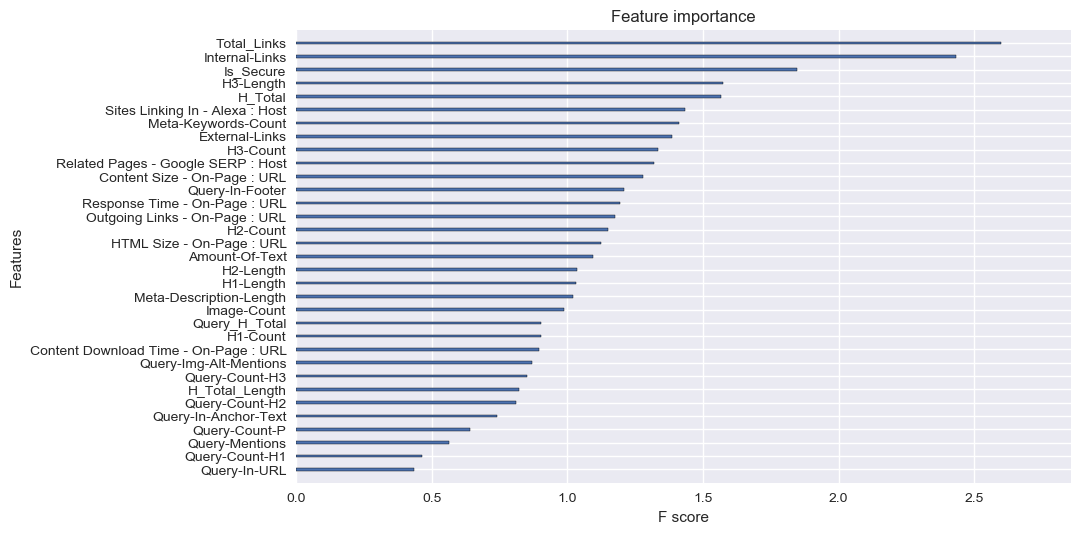

In [59]:
xgb.plot_importance(ranking_model,importance_type="gain",show_values=False)

Features about links have the highest importance overall. Security is also important when determining rank. Features about headers, specifically about header size 3 also have high importance when determining rank. Other information like outside websites linking into the site, response time, outgoing links, related pages and size of the page are helpful when determining rank. Surprisingly, features realted to the actual query made didn't garner as much importance from the model, except if the query is contained in the footer. While feature importances tells us if the feature **has** some weight when determining rank, it doesn't tell us the **direction** the feature takes the rank into. While Total Links has high weight when determining rank, does it increase or decrease the rank? Unfortunately, this feature importance score doesn't help us gauge the direction the feature takes the prediction into. For this purpose, we'll use the **SHAP** algorithm. This algorithm takes each feature of the model, and assigns a weight to it when making a prediction. This allows us to not only see how important the feature was to the final prediction, but also in which direction it affected it. We can get better insight about how the model is ranking the sites by using it. 

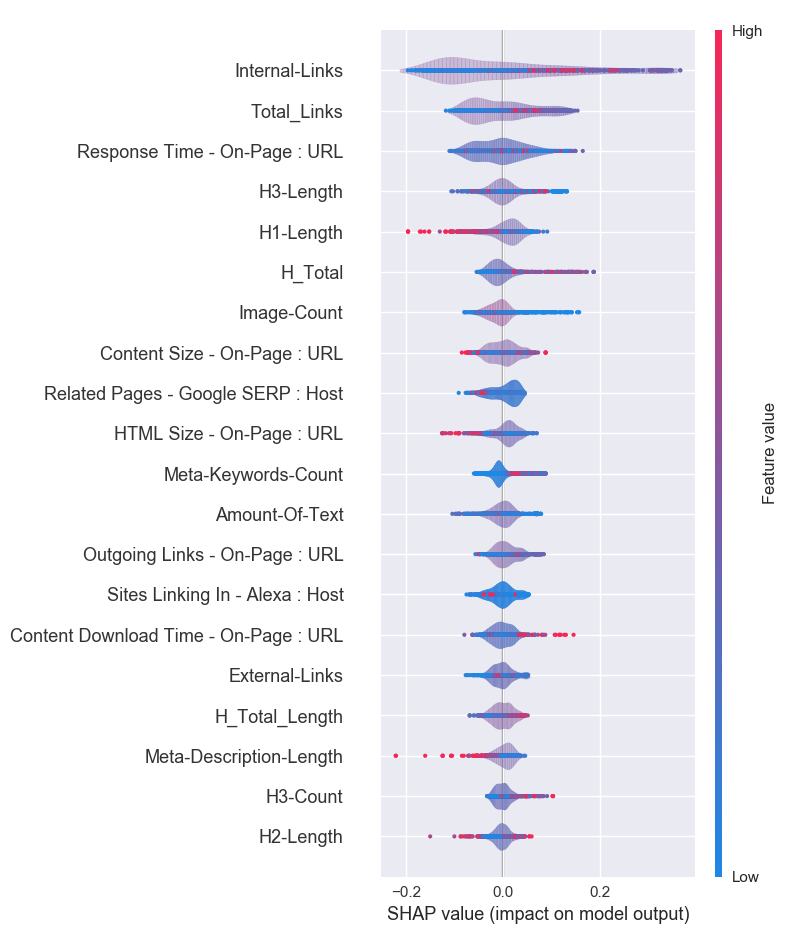

In [60]:
contribs = ranking_model.predict(xgb_data,pred_contribs=True)
X.Is_Secure = X.Is_Secure.astype(np.int8) #Convert this feature into a number, to allow for plotting.
shap.summary_plot(contribs,X,plot_type="violin")

Now we can have better insight about the model! This plot summarizes the contributions of each feature to the predictions, where the most common contributing features are at the top. It also allows us to understand how the value of the feature alters the prediction, where red points indicate high values and blue points indicate low values, and in which direction they impact the prediction. Key insights to take: 

- A higher number of internal and links overall increases the ranking. However, a very high number of links offers diminish returns in ranking.

- Mid to Low response times yeild better results for ranking.

- Long H1 tags lead to lower rankings, while a high count of headers lead to higher overall rankings. 

- Low image counts lead to higher rankings. 

- Lower amounts of related google pages lead to higher rankings, although not by much.  

And  other features can be seen in the plot. Once again, the actual query features don't seem to be contributing much into the model. However, not reducing them would have led to a very complex model. We can see how they impact the model creating a different summary plot. 

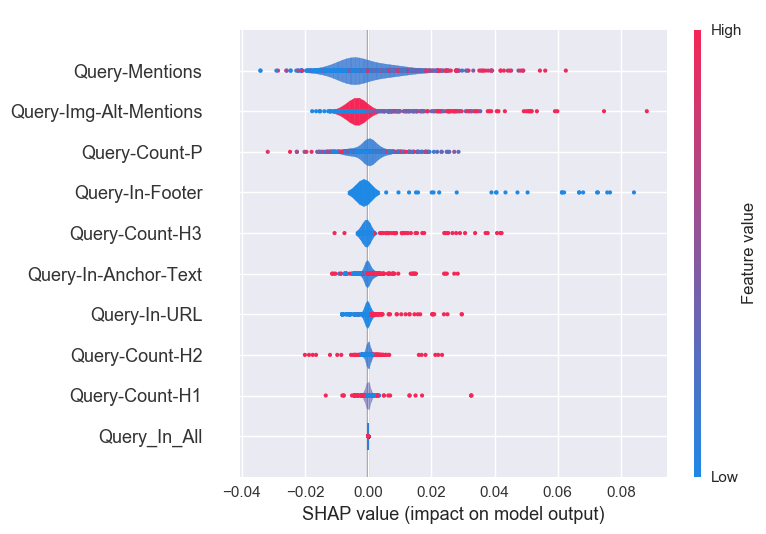

In [61]:
query_cols_indexes = [i for i,col in enumerate(X.columns) if 'Query' in col]
shap.summary_plot(contribs[:,query_cols_indexes],X.iloc[:,query_cols_indexes],plot_type="violin")

While these features have very low impact on the model, an overall theme exists that higher values for the query features yield to higher rankings. To get a better understanding of a specific ranking, let's take a look at how the contributions of an individual prediction.

In [62]:
def generate_predictions(X,contribs,groups):
    """
    Generate predicted numbered ranks for each site of the data. Slow but accurate.
    """
    predictions = []
    i = 0
    for i,group in enumerate(groups):
        group_data = X.loc[X.qid == group]
        group_size = group_data.shape[0]
        group_contribs = contribs[i:i+group_size,:]
        pred_ranks = group_contribs.sum(axis=1)
        # Convert numerical float rankings into discrete rankings.
        df_ranks = pd.DataFrame(pred_ranks,columns=['Preds'])
        df_ranks['Sort'] = df_ranks.sort_values(by='Preds').values
        df_ranks['Rank'] = 0
        for i,s in enumerate(df_ranks.Sort):
            df_ranks.loc[df_ranks.Preds == s,'Rank'] = (i + 1 )
        predictions.extend(df_ranks.Rank.values)
        i+=group_size
    return predictions

model_data['Predicted_Rank'] = generate_predictions(X,contribs,X.qid.unique())
model_data.head(10)

,Rank,H1-Count,H2-Count,H3-Count,H1-Length,H2-Length,H3-Length,Internal-Links,External-Links,Amount-Of-Text,...,Query-In-Footer,Query-Count-P,Query-Count-H1,Query-Count-H2,Query-Count-H3,Query-In-Anchor-Text,Query_In_All,Query_H_Total,qid,Predicted_Rank
10,10,1,0,6,22,0,78,925,23,39713,...,0,0,0,0,0,0,0,0,96,9
11,9,1,4,9,28,32,18,618,12,6191,...,0,1,0,0,0,0,0,0,96,8
12,8,1,53,0,24,20,0,210,8,1675,...,0,1,1,0,0,0,0,1,96,7
13,7,1,0,0,22,0,0,283,10,957,...,0,0,0,0,0,0,0,0,96,10
14,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,96,2
15,5,1,22,4,31,26,12,509,7,2791,...,0,0,0,0,0,0,0,0,96,4
16,4,1,99,0,17,42,0,568,0,8920,...,0,0,0,0,0,0,0,0,96,6
17,3,3,8,9,24,15,83,500,34,13108,...,0,0,0,0,0,0,0,0,96,5
18,2,0,2,0,0,15,0,446,6,1000,...,0,0,0,0,0,0,0,0,96,3
19,1,5,1,2,17,0,8,31,6,742,...,0,1,1,0,0,0,0,1,96,1


In [63]:
shap.initjs()

In [66]:
instance = 0
shap_X = X.drop('qid',axis=1)
print("Keyword was {}".format(query_encoder.inverse_transform(X.qid.iloc[0])))
print("Ranking was {}".format(y.iloc[instance]))
print("Predicted Ranking was {}".format(model_data.iloc[instance]['Predicted_Rank']))
shap.force_plot(contribs[instance,:], shap_X.iloc[instance,:])

Keyword was äitienpäivälahja netistä
Ranking was 10
Predicted Ranking was 9


For this particular example, the page had a high amount of internal links, a decent amount of content, and a long header 3 length. This made it rank highest on the list for this particular query. Let's take a look at all the predictions for this query.

In [69]:
y.iloc[0:10]

10    10
11     9
12     8
13     7
14     6
15     5
16     4
17     3
18     2
19     1
Name: Rank, dtype: int64

In [65]:
shap.force_plot(contribs[instance:instance+10,:], shap_X.iloc[instance:instance+10,:])

[<iml.explanations.AdditiveExplanation at 0x20c01df50f0>,
 <iml.explanations.AdditiveExplanation at 0x20c01df5eb8>,
 <iml.explanations.AdditiveExplanation at 0x20c01df50b8>,
 <iml.explanations.AdditiveExplanation at 0x20c01a7d208>,
 <iml.explanations.AdditiveExplanation at 0x20c03a67780>,
 <iml.explanations.AdditiveExplanation at 0x20c01e03438>,
 <iml.explanations.AdditiveExplanation at 0x20c01e032b0>,
 <iml.explanations.AdditiveExplanation at 0x20c04415080>,
 <iml.explanations.AdditiveExplanation at 0x20c044155c0>,
 <iml.explanations.AdditiveExplanation at 0x20c04415470>]

The highest ranked site for the model had a high amount of links, a short header 3 length, and a high count of meta keywords. However, this site was really ranked 7 in the data. The lowest ranked site had a low amount of total links, and a high content download time.

<a id='conclusion'></a>
## Conclusions and Further Improvement 

At this point, we have a clear understanding of what factors affect the ranking of websites in the search engine the data came from and how to predict ranking for new websites based on their content and the query used in the search engine. Sites that contain a high but not too high amounts  of links, with a decent amount of content, response time, and low actual size have high rankings, while those that don't accomplish the aforementioned characteristics have lower rankings. We also evaluated how good our model was at ranking, using specific metrics made for ranking. Using the right metric is extremely important, because ranking problems don't look at exact accuracy i.e, that the rankings actually match, but that the important sites according to the query appear earlier. We also obtained an intuitive understanding of search engine data's characteristics, and how even more features may be collected to better model the problem.  One major improvement is the adquisition of more query search results,  since we only used 95 query results to build the model. Having more data would allow for the use of more features, and more learning examples to further improve the algorithm. In addition, more features about the actual content of the sites, and text inside it would allow for more distinct information about each site. Even so, the results of the project are satisfactory.